In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import ast
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alici\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
df = pd.read_csv('../Data Files/Raw Data/users_ratings_img_20users_final.csv')
df.head(5)

,UserID,Title,Img_Path,Img_File_Name,Year,Description,Directors,Stars,Viewer_Advisory,Duration,...,Color2,Color3,Brightness,Contrast,Saturation,Hue,Texture,Entropy,Noise,Colorfulness
0,ur3223254,The Making of 'West Side Story',https://m.media-amazon.com/images/M/MV5BOTU3Mj...,ur3223254_1.jpg,1985,"A documentary which shows, in great detail, th...",['Christopher Swann'],"['Leonard Bernstein', 'Kiri Te Kanawa', 'José ...",Not Rated,1 hr 29 min,...,"[197.87346221441118, 183.76742823667269, 147.5...","[132.63642065649162, 67.00731758310732, 66.696...",28.345112,1.0,0.483944,0.286751,0.095318,5.033725,2607.615256,0.151818
1,ur3223254,West Side Story,https://m.media-amazon.com/images/M/MV5BMzQ5ZD...,ur3223254_2.jpg,2021,"An adaptation of the 1957 musical, West Side S...",['Steven Spielberg'],"['Ansel Elgort', 'Rachel Zegler', 'Ariana DeBo...",PG-13,2 hr 36 min,...,"[192.77984157334174, 164.10516252390104, 156.2...","[26.031522737713317, 18.571141479099744, 27.59...",56.452657,1.0,0.387084,0.630909,0.117362,7.215298,2937.235783,0.105448
2,ur3223254,Supernova,https://m.media-amazon.com/images/M/MV5BNDc0Y2...,ur3223254_3.jpg,2020,Sam and Tusker are traveling across England in...,['Harry Macqueen'],"['Colin Firth', 'Stanley Tucci', 'Pippa Haywoo...",R,1 hr 35 min,...,"[237.4783657256323, 234.21676833593577, 225.24...","[192.77753168450687, 143.20118124769283, 122.0...",129.423365,1.0,0.336827,0.314486,0.064798,7.568517,5491.649326,0.239863
3,ur3223254,The Many Saints of Newark,https://m.media-amazon.com/images/M/MV5BYmQzNm...,ur3223254_4.jpg,2021,Witness the making of Tony Soprano. The story ...,['Alan Taylor'],"['Alessandro Nivola', 'Leslie Odom Jr.', 'Jon ...",R,2 hr,...,"[227.23344529750602, 227.37020153551038, 227.3...","[123.22488696677817, 87.70277177118118, 88.950...",59.251703,1.0,0.147507,0.146196,0.076623,6.669963,6147.526922,0.116340
4,ur3223254,Never Look Away,https://m.media-amazon.com/images/M/MV5BNGUwYT...,ur3223254_5.jpg,2018,German artist Kurt Barnert has escaped East Ge...,['Florian Henckel von Donnersmarck'],"['Tom Schilling', 'Sebastian Koch', 'Paula Bee...",R,3 hr 9 min,...,"[215.23204559848062, 185.4957568081067, 188.98...","[129.6641665391094, 101.77100872493492, 107.88...",95.750548,1.0,0.333741,0.614238,0.074675,7.714849,4981.923137,0.151493


Add Years to movie title (For duplicated userid and titles row since movies can be released on different years)

In [33]:
# identify duplicate rows based on 'userid' and 'title'
duplicate_mask = df.duplicated(subset=['UserID', 'Title'], keep=False)

# apply function to add year of release to the title for each duplicate row
df.loc[duplicate_mask, 'Title'] = df[duplicate_mask].apply(lambda x: f"{x['Title']} ({x['Year']})", axis=1)
df.head(5)


,UserID,Title,Year,Description,Directors,Stars,Viewer_Advisory,Duration,Genre,Votes,Movie_Rating,User_Rating
0,ur117926588,A Nightmare on Elm Street 2: Freddy's Revenge,1985,A teenage boy is haunted in his dreams by dece...,['Jack Sholder'],"['Robert Englund', 'Mark Patton', 'Kim Myers',...",R,1 hr 27 min,Horror,72454.0,5.4,5
1,ur117926588,Elvis,2022,The life of American music icon,['Baz Luhrmann'],"['Tom Hanks', 'Austin Butler', 'Olivia DeJonge...",PG-13,2 hr 39 min,"Biography, Drama, Music",196677.0,7.3,8
2,ur117926588,Where Eagles Dare,1968,Allied agents stage a daring raid on a castle ...,['Brian G. Hutton'],"['Richard Burton', 'Clint Eastwood', 'Mary Ure...",M,2 hr 38 min,"Action, Adventure, War",59856.0,7.6,9
3,ur117926588,A Nightmare on Elm Street (1984),1984,Teenager Nancy Thompson must uncover the dark ...,['Wes Craven'],"['Heather Langenkamp', 'Johnny Depp', 'Robert ...",R,1 hr 31 min,Horror,245805.0,7.4,9
4,ur117926588,Eagle Eye,2008,Jerry and Rachel are two strangers thrown toge...,['D.J. Caruso'],"['Shia LaBeouf', 'Michelle Monaghan', 'Rosario...",PG-13,1 hr 58 min,"Action, Mystery, Thriller",189895.0,6.6,5


# Feature Engineering

#### Get number of years from now using Year column 

In [35]:
df['Year'].unique()

array(['1985', '2022', '1968', '1984', '2008', '2023', '2000', '1994',
       '2003', '2005', '1953', '2001', '2015', '1991', '1997', '1995',
       '1993', '1992', '2012', '1986', '1996', '1980', '1979', '2023–',
       '2011', '1987', '1989', '1981', '1999', '1988', '1990', '1998',
       '1974', '2021', '2007', '2004', '2014–2017', '1993–1994', '2018',
       '2022–', '2006', '1950', '1963', '1982', '1948', '2013', '2016',
       '1978', '1977', '2014', '2010', '1973', '1966', '2019',
       '2010–2015', '2017', '1951', '2009', '1991–1992', '1983', '2021–',
       '1965', '2002', '1971', '1946', '1976', '1961', '1964',
       '2007–2019', '1941', '1962', '1940', '1975', '1952', '1955',
       '2014–2020', '1943', '2020–2023', '1989–1990', '1970', '1956',
       '2003–2006', '2000–2004', '2015–2017', '1947', '2020', '2019–',
       '1998–1999', '2014–', '1992–1997', '2013–2016', '1959', '1932',
       '2005–2007', '2015–2018', '1938', '1942', '1959–1963', '1988–1999',
       '2020–',

In [36]:
df['num_years_released'] = df['Year'].apply(lambda x: 2023 - int(x) if len(x.split('–')) == 0 else 2023 - int(x.split('–')[0]))
df.head(5)

,UserID,Title,Year,Description,Directors,Stars,Viewer_Advisory,Duration,Genre,Votes,Movie_Rating,User_Rating,num_years_released
0,ur117926588,A Nightmare on Elm Street 2: Freddy's Revenge,1985,A teenage boy is haunted in his dreams by dece...,['Jack Sholder'],"['Robert Englund', 'Mark Patton', 'Kim Myers',...",R,1 hr 27 min,Horror,72454.0,5.4,5,38
1,ur117926588,Elvis,2022,The life of American music icon,['Baz Luhrmann'],"['Tom Hanks', 'Austin Butler', 'Olivia DeJonge...",PG-13,2 hr 39 min,"Biography, Drama, Music",196677.0,7.3,8,1
2,ur117926588,Where Eagles Dare,1968,Allied agents stage a daring raid on a castle ...,['Brian G. Hutton'],"['Richard Burton', 'Clint Eastwood', 'Mary Ure...",M,2 hr 38 min,"Action, Adventure, War",59856.0,7.6,9,55
3,ur117926588,A Nightmare on Elm Street (1984),1984,Teenager Nancy Thompson must uncover the dark ...,['Wes Craven'],"['Heather Langenkamp', 'Johnny Depp', 'Robert ...",R,1 hr 31 min,Horror,245805.0,7.4,9,39
4,ur117926588,Eagle Eye,2008,Jerry and Rachel are two strangers thrown toge...,['D.J. Caruso'],"['Shia LaBeouf', 'Michelle Monaghan', 'Rosario...",PG-13,1 hr 58 min,"Action, Mystery, Thriller",189895.0,6.6,5,15


#### Cleaned up and merged similar viewer advisory

In [37]:
df['Viewer_Advisory'].unique()

array(['R', 'PG-13', 'M', 'PG', 'G', 'Unrated', 'TV-MA', 'TV-Y7',
       'TV-Y7-FV', 'Not Rated', 'Approved', 'Passed', nan, 'TV-PG',
       'TV-Y', 'TV-14', 'TV-G', 'NC-17', 'MA-17', 'NC16', 'NC-16', '16+',
       'E', '12', 'PG13', 'M18', 'X', 'AO', '13+', 'GP', 'M/PG', 'R21',
       'K-A', 'T', 'E10+', 'R(A)'], dtype=object)

In [38]:
def merge_viewer(x):
    gp = ['G', 'GP', 'E']
    pg = ['PG-13', 'PG','PG13', 'TV-PG', '13+', 'M/PG', 'T']
    tv = ['TV-Y', 'TV-Y7', 'TV-Y7-FV', 'TV-G', 'TV-14']
    nc = ['NC-17', 'MA-17', 'NC16', 'NC-16', '17+', '16+', 'X']
    m = ['M', "M-18", 'TV-MA']
    r =['R', 'R21']
    unrated = ['Unrated', 'Not Rated', 'Approved', 'Passed']
    others = ['12', 'AO', 'K-A', 'E10+', 'R(A)', 'E']
    
    if x in pg:
        return "PG"
    elif x in gp:
        return 'GP'
    elif x in tv:
        return 'TV'
    elif x in nc:
        return "NC-17"
    elif x in m:
        return "M"
    elif x in r:
        return "R21"
    elif x in unrated or not isinstance(x,str):
        return "Unrated"
    elif x in others:
        return "Others"
    else:
        return x
    
df['Viewer_Advisory'] = df['Viewer_Advisory'].apply(merge_viewer)

In [39]:
df['Viewer_Advisory'].unique()

array(['R21', 'PG', 'M', 'GP', 'Unrated', 'TV', 'NC-17', 'Others', 'M18'],
      dtype=object)

#### Convert movie duration to minutes

In [40]:
def convert_to_mins(x):
    if not isinstance(x, str):
        return x
    elif len(x.split(" "))>2:
        return 60*int(x.split(" ")[0]) + int(x.split(" ")[2])
    else:
        return int(x.split(" ")[0])
                   
df['viewer_cat'] = df['Viewer_Advisory'].astype('category').cat.codes
df['duration_mins'] = df['Duration'].apply(convert_to_mins)
df.head(5)             

,UserID,Title,Year,Description,Directors,Stars,Viewer_Advisory,Duration,Genre,Votes,Movie_Rating,User_Rating,num_years_released,viewer_cat,duration_mins
0,ur117926588,A Nightmare on Elm Street 2: Freddy's Revenge,1985,A teenage boy is haunted in his dreams by dece...,['Jack Sholder'],"['Robert Englund', 'Mark Patton', 'Kim Myers',...",R21,1 hr 27 min,Horror,72454.0,5.4,5,38,6,87.0
1,ur117926588,Elvis,2022,The life of American music icon,['Baz Luhrmann'],"['Tom Hanks', 'Austin Butler', 'Olivia DeJonge...",PG,2 hr 39 min,"Biography, Drama, Music",196677.0,7.3,8,1,5,159.0
2,ur117926588,Where Eagles Dare,1968,Allied agents stage a daring raid on a castle ...,['Brian G. Hutton'],"['Richard Burton', 'Clint Eastwood', 'Mary Ure...",M,2 hr 38 min,"Action, Adventure, War",59856.0,7.6,9,55,1,158.0
3,ur117926588,A Nightmare on Elm Street (1984),1984,Teenager Nancy Thompson must uncover the dark ...,['Wes Craven'],"['Heather Langenkamp', 'Johnny Depp', 'Robert ...",R21,1 hr 31 min,Horror,245805.0,7.4,9,39,6,91.0
4,ur117926588,Eagle Eye,2008,Jerry and Rachel are two strangers thrown toge...,['D.J. Caruso'],"['Shia LaBeouf', 'Michelle Monaghan', 'Rosario...",PG,1 hr 58 min,"Action, Mystery, Thriller",189895.0,6.6,5,15,5,118.0


#### Merge Similar Genre

In [42]:
df['genre_list'] = df['Genre'].apply(lambda x: x.strip().replace(" ",  "").split(","))

unique_genres = set()
for genres in df["genre_list"]:
    unique_genres.update(genres)

unique_genres

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western'}

In [43]:
len(unique_genres)

27

In [44]:
def merge_genres(x):
    act_ad_scifi = ['Adventure', 'Sci-Fi', 'Fantasy']
    reality = ['Documentary', 'Reality-TV', 'News', 'Talk-Show', 'Game-Show']
    horror_thriller = ['Horror', "Thriller"]
    crime_mystery = ['Crime', 'Mystery']
    drama = ['Drama', 'Biography']
    music = ['Music', 'Musical']
    sport_action = ['Sport', 'Action']
    war_hist = ['War', "History"]

    new_genre_list = []

    for g in x:
        if g in act_ad_scifi and g not in new_genre_list:
            new_genre_list.append('Ad/SciFi/Fantasy')
        elif g in reality and g not in new_genre_list:
            new_genre_list.append('Reality')
        elif g in horror_thriller and g not in new_genre_list:
            new_genre_list.append('Horror/Thriller')
        elif g in crime_mystery and g not in new_genre_list:
            new_genre_list.append('Crime/Mystery')
        elif g in drama and g not in new_genre_list:
            new_genre_list.append('Drama')
        elif g in music and g not in new_genre_list:
            new_genre_list.append('Music')
        elif g in sport_action and g not in new_genre_list:
            new_genre_list.append('Sport/Action')
        elif g in war_hist and g not in new_genre_list:
            new_genre_list.append('War/History')
        else:
            new_genre_list.append(g)

    return new_genre_list

df['genre_list'] = df['genre_list'].apply(merge_genres)
df['genre_list']
    

0                                     [Horror/Thriller]
1                                 [Drama, Drama, Music]
2         [Sport/Action, Ad/SciFi/Fantasy, War/History]
3                                     [Horror/Thriller]
4        [Sport/Action, Crime/Mystery, Horror/Thriller]
                              ...                      
15590           [Crime/Mystery, Drama, Horror/Thriller]
15591                [Drama, Ad/SciFi/Fantasy, Romance]
15592           [Crime/Mystery, Drama, Horror/Thriller]
15593                                         [Reality]
15594                                           [Drama]
Name: genre_list, Length: 15595, dtype: object

#### Preprocess Text

In [72]:
df['Title'] = df['Title'].fillna(' ')
df['Description'] = df['Description'].fillna(' ')
df['title_desc'] = df['Title'] + ' ' + df['Description']
df['title_desc'][0]

"A Nightmare on Elm Street 2: Freddy's Revenge A teenage boy is haunted in his dreams by deceased child murderer Freddy Krueger, who is out to possess him in order to continue his reign of terror in the real world."

In [73]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower().strip()

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenize text
    tokens = nltk.word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Stem words
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['title_desc'] = df['title_desc'].apply(preprocess_text)
df['Title'] = df['Title'].apply(preprocess_text)

# Label Encoding and One Hot Encoding

In [75]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
res1 = pd.DataFrame(mlb.fit_transform(df['genre_list']),
                   columns=mlb.classes_,
                   index=df.index)
df = pd.concat([df, res1], axis = 1)

In [76]:
df.head(2)

,UserID,Title,Year,Description,Directors,Stars,Viewer_Advisory,Duration,Genre,Votes,...,Family,Film-Noir,Horror/Thriller,Music,Reality,Romance,Short,Sport/Action,War/History,Western
0,ur117926588,nightmar elm street freddi reveng,1985,A teenage boy is haunted in his dreams by dece...,['Jack Sholder'],"['Robert Englund', 'Mark Patton', 'Kim Myers',...",R21,1 hr 27 min,Horror,72454.0,...,0,0,1,0,0,0,0,0,0,0
1,ur117926588,elvi,2022,The life of American music icon,['Baz Luhrmann'],"['Tom Hanks', 'Austin Butler', 'Olivia DeJonge...",PG,2 hr 39 min,"Biography, Drama, Music",196677.0,...,0,0,0,1,0,0,0,0,0,0


In [77]:
df.drop(columns= ['UserID',  'Year', 'Description', 'Directors', 'Stars', 'Viewer_Advisory', 'Duration', 'Genre', 'genre_list'], inplace=True)

In [95]:
# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer()

# Fit the vectorizer to the text data
tfidf_matrix = tfidf.fit_transform(df['title_desc'])

# # Compute SVD with 2 dimensions
# svd = TruncatedSVD(n_components=2)
# svd_matrix = svd.fit_transform(tfidf_matrix)

# # Convert the matrix to a Pandas DataFrame
# svd_df = pd.DataFrame(svd_matrix, columns=['SVD_1', 'SVD_2'])

# # Concatenate the TF-IDF DataFrame with the year column
# df_final = pd.concat([df,svd_df], axis=1)

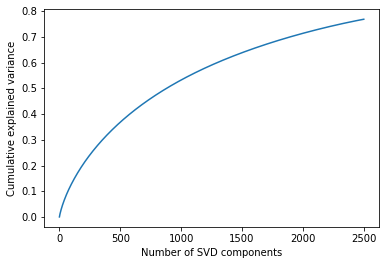

In [96]:
# Create a TruncatedSVD object
svd = TruncatedSVD(n_components=2500)

# Fit and transform the TF-IDF matrix
svd_matrix = svd.fit_transform(tfidf_matrix)

# Compute the explained variance for each component
explained_variance = svd.explained_variance_ratio_

# Compute the cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plot the cumulative explained variance
plt.plot(cumulative_variance)
plt.xlabel('Number of SVD components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [93]:
# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer()

# Fit the vectorizer to the text data
tfidf_matrix = tfidf.fit_transform(df['Title'])

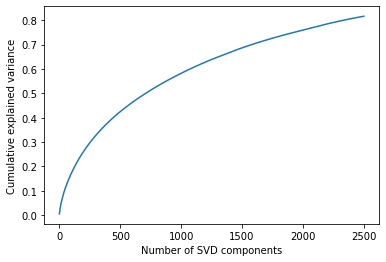

In [94]:
# Create a TruncatedSVD object
svd = TruncatedSVD(n_components=2500)

# Fit and transform the TF-IDF matrix
svd_matrix = svd.fit_transform(tfidf_matrix)

# Compute the explained variance for each component
explained_variance = svd.explained_variance_ratio_

# Compute the cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plot the cumulative explained variance
plt.plot(cumulative_variance)
plt.xlabel('Number of SVD components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [81]:
df_final.drop(columns=['Title', 'title_desc'], inplace= True)

In [82]:
df_final.head(5)

,Votes,Movie_Rating,User_Rating,num_years_released,viewer_cat,duration_mins,Ad/SciFi/Fantasy,Animation,Comedy,Crime/Mystery,...,Horror/Thriller,Music,Reality,Romance,Short,Sport/Action,War/History,Western,SVD_1,SVD_2
0,72454.0,5.4,5,38,6,87.0,0,0,0,0,...,1,0,0,0,0,0,0,0,0.001341,0.003042
1,196677.0,7.3,8,1,5,159.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0.000006,0.000044
2,59856.0,7.6,9,55,1,158.0,1,0,0,0,...,0,0,0,0,0,1,1,0,0.000186,0.000164
3,245805.0,7.4,9,39,6,91.0,0,0,0,0,...,1,0,0,0,0,0,0,0,0.001235,0.001111
4,189895.0,6.6,5,15,5,118.0,0,0,0,1,...,1,0,0,0,0,1,0,0,0.007190,0.002542


In [ ]:
# create boolean mask of NaN values
nan_mask = df_final.isna()

# count number of True values in each column
nan_count = nan_mask.sum(axis=0)

# print number of NaN values in each column
print(nan_count/len(df_final))

Votes                 0.000128
Movie_Rating          0.000000
User_Rating           0.000000
num_years_released    0.000000
viewer_cat            0.000000
                        ...   
zootopia              0.000000
zorba                 0.000000
zorro                 0.000000
zumbo                 0.000000
½th                   0.000000
Length: 6892, dtype: float64


# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

x = df_final.loc[:, df_final.columns != "User_Rating"]
y = df_final.loc[:, df_final.columns == 'User_Rating']


X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state= 123)

#### Fill na values with mean and scaling for train and test set

In [ ]:
#fill na values with mean
X_train['Votes'] = X_train['Votes'].fillna(X_train['Votes'].mean())
X_test['Votes'] = X_test['Votes'].fillna(X_test['Votes'].mean())

X_train['duration_mins'] = X_train['duration_mins'].fillna(X_train['duration_mins'].mean())
X_test['duration_mins'] = X_test['duration_mins'].fillna(X_test['duration_mins'].mean())

scaler = StandardScaler()
col_to_scale = ['Votes', 'Movie_Rating', 'num_years_released','duration_mins']
X_train[col_to_scale] = scaler.fit_transform(X_train[col_to_scale])
X_test[col_to_scale] = scaler.fit_transform(X_test[col_to_scale])


In [70]:
Y_train

,User_Rating
2144,8
5322,7
13045,7
14218,7
2003,7
...,...
5218,5
12252,5
1346,6
11646,8


In [71]:
# X_train.to_csv('../Data Files/Training Data/x_train.csv', index= False)
# X_test.to_csv('../Data Files/Training Data/x_test.csv', index= False)

# Y_train.to_csv('../Data Files/Training Data/y_train.csv', index=False)
# Y_test.to_csv('../Data Files/Training Data/y_test.csv', index=False)